# Обучение модели

1. Проведите небольшой описательный анализ данных
2. Решите задачу классификации подготовленных данных по определенным ранее вами классам
3. Выберите метрики, по которым будете интерпретировать результат.
4. Объясните ваш выбор метрик
5. Интерпретируйте и визуализируйте полученные результаты

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

1. Проведите небольшой описательный анализ данных

In [21]:
# создадим dataframe из данных, полученных в задании 3, прочитав все файлы
filename = 'rshb_reviews.csv'
reviews_df = pd.read_csv(filename)

In [22]:
reviews_df.info() # получили 8000 комментариев для обучения модели

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8107 entries, 0 to 8106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   title   8107 non-null   object 
 1   url     8107 non-null   object 
 2   text    8107 non-null   object 
 3   score   6354 non-null   float64
 4   date    8107 non-null   object 
 5   label   8107 non-null   object 
dtypes: float64(1), object(5)
memory usage: 380.1+ KB


Данные носят преимущественно текстовый характер.

In [55]:
reviews_df.groupby('label')['score'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
credit,936.0,3.238248,1.885455,1.0,1.0,5.0,5.0,5.0
debitcard,1689.0,2.256957,1.735891,1.0,1.0,1.0,5.0,5.0
deposit,1448.0,2.831492,1.845985,1.0,1.0,2.0,5.0,5.0
hypothec,2266.0,2.350838,1.759752,1.0,1.0,1.0,5.0,5.0


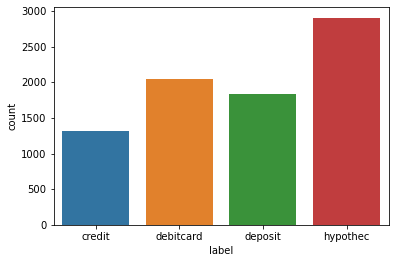

In [56]:
sns.countplot(data=reviews_df, x='label') # как видим, по ипотеке отзывов больше всего
plt.gca().set_title('Количесто по классам')

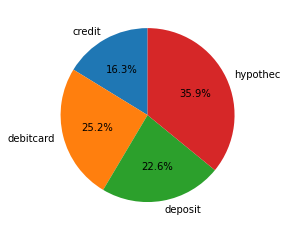

In [57]:
reviews_df.groupby('label').count()['title'].plot.pie(y='label', startangle=90, autopct="%.1f%%")
plt.gca().set_ylabel('')
plt.show()

Text(0.5, 1.0, 'Средние оценки по отзывам')

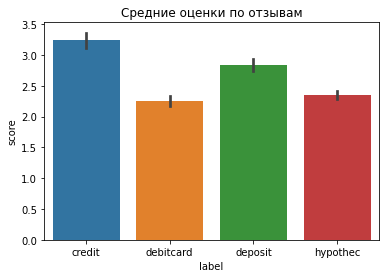

In [58]:
sns.barplot(x='label', y='score', data=reviews_df)
plt.gca().set_title('Средние оценки по классам')

##### Очистка данных

In [89]:
# функция очистки текста от лишних символов
# можно модифицировать - убрать предлоги и союзы
def standartize_text(df, field):
    # удаляем все названия сайтов
    df[field] = df[field].str.replace(r"http\S+", "")
    df[field] = df[field].str.replace(r"http", "")
    # удаляем все адреса электронной почты
    df[field] = df[field].str.replace(r"@\S+", "")
    # удаляем все символы, кроме букв, цифр, скобок и кавычек
    df[field] = df[field].str.replace(r"[^A-Za-zА-Яа-яёЁ0-9(),!?\'\`\"\_\n]", " ") # раньше ещё был @
    # переводим всё в нижний регистр
    df[field] = df[field].str.lower()
    return df

In [90]:
reviews_clear_df = standartize_text(reviews_df, 'text')[['text', 'label']]

In [91]:
reviews_clear_df.head()

,text,label
0,добрый день !!! хочу написать благодарность...,credit
1,добрый день! подавал заявки на кредит в банки ...,credit
2,требование решить вопрос о корректном закрытии...,credit
3,осенью 2019 г взял потребительский кредит 25 ...,credit
4,"здравствуйте, хотел бы оставить отзыв о хороше...",credit


Присвоим классам числовые метки:

In [92]:
label_encoding = {'credit': 0, 'hypothec': 1, 'debitcard': 2, 'deposit': 3}

In [93]:
reviews_clear_df['class_label'] = reviews_clear_df['label'].map(label_encoding)

<ipython-input-93-5e995461a8f3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_clear_df['class_label'] = reviews_clear_df['label'].map(label_encoding)


In [94]:
reviews_clear_df.head()

,text,label,class_label
0,добрый день !!! хочу написать благодарность...,credit,0
1,добрый день! подавал заявки на кредит в банки ...,credit,0
2,требование решить вопрос о корректном закрытии...,credit,0
3,осенью 2019 г взял потребительский кредит 25 ...,credit,0
4,"здравствуйте, хотел бы оставить отзыв о хороше...",credit,0


### Добавление токенов

In [95]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

reviews_clear_df["tokens"] = reviews_clear_df["text"].apply(tokenizer.tokenize)
reviews_clear_df.head()

<ipython-input-95-8c96ce46b99c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_clear_df["tokens"] = reviews_clear_df["text"].apply(tokenizer.tokenize)


,text,label,class_label,tokens
0,добрый день !!! хочу написать благодарность...,credit,0,"[добрый, день, хочу, написать, благодарность, ..."
1,добрый день! подавал заявки на кредит в банки ...,credit,0,"[добрый, день, подавал, заявки, на, кредит, в,..."
2,требование решить вопрос о корректном закрытии...,credit,0,"[требование, решить, вопрос, о, корректном, за..."
3,осенью 2019 г взял потребительский кредит 25 ...,credit,0,"[осенью, 2019, г, взял, потребительский, креди..."
4,"здравствуйте, хотел бы оставить отзыв о хороше...",credit,0,"[здравствуйте, хотел, бы, оставить, отзыв, о, ..."


### Продолжение анализа

In [105]:
all_words = [word for tokens in reviews_clear_df['tokens'] for word in tokens]
reviews_lengths = [len(tokens) for tokens in reviews_clear_df['tokens']]
VOCAB = sorted(list(set(all_words)))
print(f'{len(all_words)} всего слов, со словарем размером {len(VOCAB)}')
print(f'Максимальная длина отзыва: {max(reviews_lengths)}')

1356748 всего слов, со словарем размером 55758
Максимальная длина отзыва: 2502


Text(0.5, 0, 'Длина отзыва')

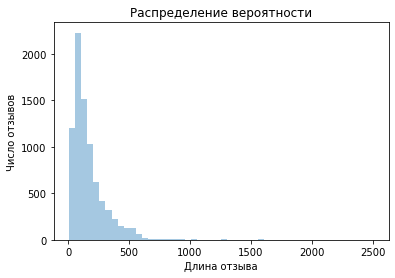

In [125]:
sns.distplot(reviews_lengths, kde=False)
ax = plt.gca()
ax.set_title('Число отзывов разной длины')
ax.set_ylabel('Число отзывов')
ax.set_xlabel('Длина отзыва')

Посмотрим детальнее:

Text(0.5, 0, 'Длина отзыва')

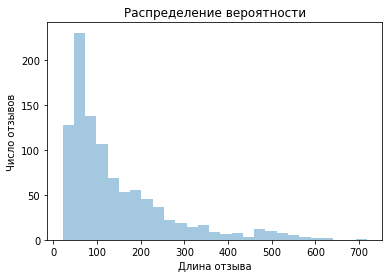

In [130]:
sns.distplot(reviews_lengths[:1000], kde=False)
ax = plt.gca()
ax.set_title('Число отзывов разной длины')
ax.set_ylabel('Число отзывов')
ax.set_xlabel('Длина отзыва')

In [ ]:
# Как видно на графике, чаще всего отзывы меньше 200 слов

In [172]:
from collections import Counter
all_words_freq = Counter(all_words)

In [176]:
# самые распространенные слова можно убрать - они вносят шум в модель - TODO
all_words_freq.most_common()

[('в', 53387),
 ('и', 40005),
 ('не', 28979),
 ('на', 27027),
 ('что', 21416),
 ('я', 17008),
 ('с', 16653),
 ('по', 14825),
 ('банка', 11141),
 ('мне', 9632),
 ('банк', 8519),
 ('за', 8372),
 ('а', 8129),
 ('к', 7502),
 ('как', 7161),
 ('но', 6726),
 ('все', 6528),
 ('это', 6146),
 ('у', 6110),
 ('меня', 5899),
 ('так', 5373),
 ('то', 5371),
 ('о', 5351),
 ('для', 5181),
 ('от', 4200),
 ('было', 4082),
 ('же', 3909),
 ('при', 3785),
 ('уже', 3683),
 ('до', 3679),
 ('из', 3504),
 ('нет', 3366),
 ('только', 3281),
 ('день', 3275),
 ('мы', 3259),
 ('очень', 3256),
 ('деньги', 3196),
 ('банке', 3108),
 ('г', 3077),
 ('через', 3029),
 ('отделение', 2964),
 ('2', 2956),
 ('карту', 2913),
 ('карты', 2777),
 ('1', 2752),
 ('офис', 2698),
 ('документы', 2624),
 ('время', 2618),
 ('10', 2605),
 ('кредит', 2565),
 ('т', 2512),
 ('после', 2509),
 ('был', 2493),
 ('если', 2486),
 ('она', 2463),
 ('года', 2353),
 ('раз', 2323),
 ('чтобы', 2287),
 ('этом', 2276),
 ('была', 2257),
 ('ни', 2255),
 ('е

### Применение машиинного обучения

Создаём векторное представление

In [132]:
reviews_clear_df.head()

,text,label,class_label,tokens
0,добрый день !!! хочу написать благодарность...,credit,0,"[добрый, день, хочу, написать, благодарность, ..."
1,добрый день! подавал заявки на кредит в банки ...,credit,0,"[добрый, день, подавал, заявки, на, кредит, в,..."
2,требование решить вопрос о корректном закрытии...,credit,0,"[требование, решить, вопрос, о, корректном, за..."
3,осенью 2019 г взял потребительский кредит 25 ...,credit,0,"[осенью, 2019, г, взял, потребительский, креди..."
4,"здравствуйте, хотел бы оставить отзыв о хороше...",credit,0,"[здравствуйте, хотел, бы, оставить, отзыв, о, ..."


In [133]:
# мешок слов
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()
    emb = count_vectorizer.fit_transform(data)
    return emb, count_vectorizer

list_corpus = reviews_clear_df["text"].tolist()
list_labels = reviews_clear_df["class_label"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

Визуализация векторных представлений

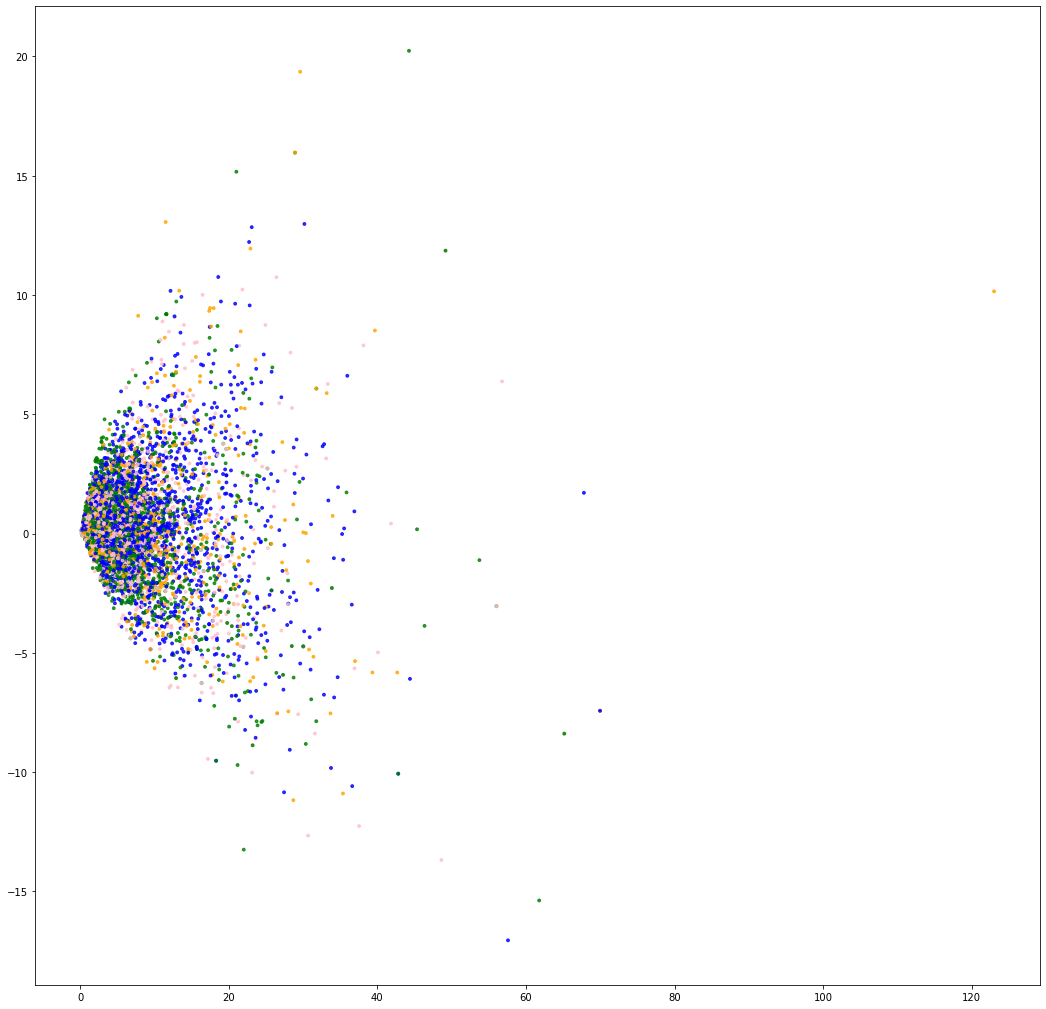

In [171]:
# TODO: GRAPHICS
import numpy as np
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(test_data)
    lsa_scores = lsa.transform(test_data)
    color_mapper = {label:idx for idx, label in enumerate(set(test_labels))}
    color_column = [color_mapper[label] for label in test_labels]
    colors = ['orange','blue', 'red', 'green', 'pink']
    if plot:
        plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels,
                    cmap=matplotlib.colors.ListedColormap(colors))
#             red_patch = mpatches.Patch(color='orange', label='Irrelevant')
#             green_patch = mpatches.Patch(color='blue', label='Disaster')
#             plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(18, 18))          
plot_LSA(X_train_counts, y_train)
plt.show()

Строим модель классификатора

In [157]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)
y_predicted_counts = clf.predict(X_test_counts)

Оцениваем классификатор

In [163]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # tp / (tp + fp)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # tp / (tp + fp)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # гармоническое среднее precision и recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # tp + tn/ tp + tn + fp + fn
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print(f"accuracy = {accuracy:.3f}, precision = {precision:.3f}, recall = {recall:.3f}, f1 = {f1:.3f}")

accuracy = 0.751, precision = 0.752, recall = 0.751, f1 = 0.752


Получаем точность в 75%, не так уж и плохо, но хочется лучше.

2. Решите задачу классификации подготовленных данных по определенным ранее вами классам

3. Выберите метрики, по которым будете интерпретировать результат.

4. Объясните ваш выбор метрик

5. Интерпретируйте и визуализируйте полученные результаты

Теперь проведём анализ данных, собранных ранее, и построим модель, которая будет с помощью NLP классифицировать, о каком типе услуг написан некоторый отзыв.